In [1]:
import os
import sys
sys.path.insert(1, '../src/')
import utils as ut
import evals as evals
import scot2 as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ot
import pandas as pd

In [2]:
### Change working directory to /data in order to import the data
os.chdir("../data/")

### Read and normalize the data:
X=np.loadtxt("acc_30.txt")
y=np.loadtxt("met_30.txt")
z=np.loadtxt("rna_30.txt")
X_labels = np.loadtxt("acc_stage.txt")
y_labels = np.loadtxt("met_stage.txt")
z_labels = np.loadtxt("rna_stage.txt")

X=ut.unit_normalize(X)
y=ut.unit_normalize(y)
z=ut.unit_normalize(z)
print(X.shape)
print(y.shape)
print(z.shape)

(647, 30)
(725, 30)
(597, 30)


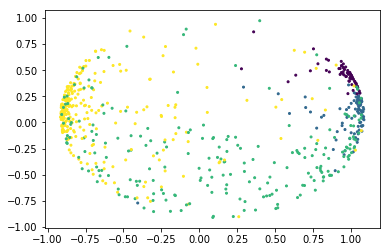

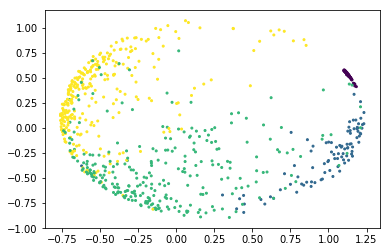

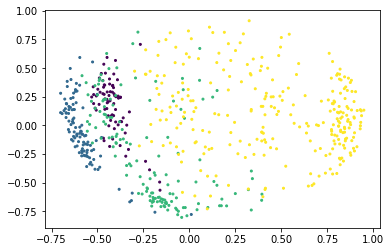

In [3]:
### plot the data
pca=PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:, 1], s = 4, c = X_labels)
plt.show()

y_pca = pca.fit_transform(y)
plt.scatter(y_pca[:,0], y_pca[:, 1], s = 4, c = y_labels)
plt.show()

z_pca = pca.fit_transform(z)
plt.scatter(z_pca[:,0], z_pca[:, 1], s = 4, c = z_labels)
plt.show()


# Balanced Alignment

In [4]:
# initialize SCOT object (with X projected onto y)
scot=sc.SCOT(X, y)
X_new, y_new = scot.align(k=60, e=0.007, normalize=False, balanced = True)
gXy = scot.coupling

It.  |Err         
-------------------
    0|7.835771e-04|
   10|1.728572e-04|
   20|8.279779e-07|
   30|1.258105e-07|
   40|3.087533e-08|
   50|7.578022e-09|
   60|1.859885e-09|
   70|4.564717e-10|


In [5]:
# compute label transfer accuracy 
lta=evals.transfer_accuracy(X_new, y_new, X_labels, y_labels, 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(y_new, X_new, y_labels, X_labels, 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with X onto Y is:  0.794435857805255
Label transfer accuracy for this alignment with X onto Y is:  0.7903448275862069


In [6]:
# initialize SCOT object (with z projected onto y)
scot=sc.SCOT(z, y)
z_new, y_new = scot.align(k=5, e=0.007, normalize=False, balanced = True)
gzy = scot.coupling

It.  |Err         
-------------------
    0|1.942297e-03|
   10|1.080499e-04|
   20|1.207234e-06|
   30|2.208901e-08|
   40|4.600396e-10|


In [7]:
# compute label transfer accuracy between y,z
lta=evals.transfer_accuracy(z_new, y_new, z_labels, y_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(y_new, z_new, y_labels, z_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with Z onto Y is:  0.8927973199329984
Label transfer accuracy for this alignment with Z onto Y is:  0.7737931034482759


In [8]:
# compute label transfer accuracy between z, X (going through y)
lta=evals.transfer_accuracy(z_new, X_new, z_labels, X_labels, 5)
print("Label transfer accuracy for this alignment with Z onto X is: ", np.mean(lta))

lta=evals.transfer_accuracy(X_new, z_new, X_labels, z_labels, 5)
print("Label transfer accuracy for this alignment with Z onto X is: ", np.mean(lta))

Label transfer accuracy for this alignment with Z onto X is:  0.8291457286432161
Label transfer accuracy for this alignment with Z onto X is:  0.7465224111282844


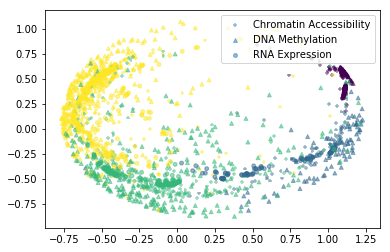

In [9]:
# plot the transport
Xyz_pca = pca.fit_transform(np.concatenate((X_new, y_new, z_new), axis=0))
X_pca = Xyz_pca[0:X.shape[0],]
y_pca = Xyz_pca[X.shape[0]:X.shape[0]+y.shape[0],]
z_pca = Xyz_pca[X.shape[0]+y.shape[0]:,]

plt.scatter(X_pca[:,0], X_pca[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = X_labels, marker = "+")
plt.scatter(y_pca[:,0], y_pca[:,1], s=15, label="DNA Methylation", alpha = 0.5, c = y_labels, marker = "^")
plt.scatter(z_pca[:,0], z_pca[:,1], s=15, label="RNA Expression", alpha = 0.5, c = z_labels, marker = "o")
plt.legend()
plt.show()

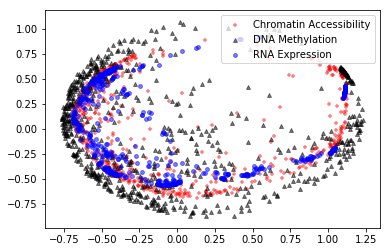

In [10]:
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = 'r', marker = "+")
plt.scatter(y_pca[:,0], y_pca[:,1], s=15, label="DNA Methylation", alpha = 0.5, c = 'k', marker = "^")
plt.scatter(z_pca[:,0], z_pca[:,1], s=15, label="RNA Expression", alpha = 0.5, c = 'b', marker = "o")
plt.legend()
plt.show()

In [11]:
lta = np.zeros(10)
for i in range(10):
    Xyz = np.concatenate(( X_new, y_new, z_new))
    Xyz_labels = np.concatenate((X_labels, y_labels, z_labels))
    sub_idx = np.random.permutation(Xyz.shape[0])
    Xyz = Xyz[sub_idx, :]
    Xyz_labels = Xyz_labels[sub_idx]

    lta[i]=evals.transfer_accuracy(Xyz[:(Xyz.shape[0] //2),:], Xyz[(Xyz.shape[0] //2):,:], 
                                Xyz_labels[:(Xyz.shape[0] //2)].reshape(-1, 1), Xyz_labels[(Xyz.shape[0] //2):].reshape(-1, 1), 5)

print("Label transfer accuracy for randomly splitting the alignment data is ", np.mean(lta))


../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(d

Label transfer accuracy for randomly splitting the alignment data is  0.8615853658536585


# Unbalanced

In [12]:
### Read and normalize the new data:
X=np.loadtxt("acc_30_removeE45.txt")
X_labels = np.loadtxt("acc_stage_removeE45.txt")
X=ut.unit_normalize(X)
print(X.shape)

(584, 30)


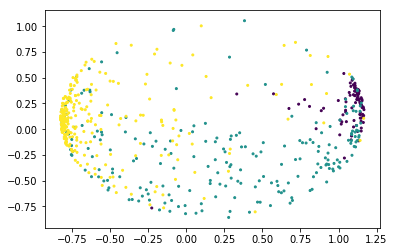

In [26]:
# plot the new data
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:, 1], s = 4, c = X_labels)
plt.show()

In [13]:
# save indices without the missing class in acc
y_idx = y_labels != 0
z_idx = z_labels != 0

In [14]:
# initialize SCOT object (with X projected onto y)
scot=sc.SCOT(X, y)
X_new, y_new = scot.align(k=70, e=0.005, rho = 0.5, normalize=False, balanced = False)
gXy_u = scot.coupling

It.  |Err         
-------------------
    0|1.173435e-03|
   10|7.179718e-05|
   20|1.749898e-06|
   30|6.985066e-08|


In [15]:
# compute label transfer accuracy without the missing class
lta=evals.transfer_accuracy(X_new, y_new[y_idx, :], X_labels, y_labels[y_idx], 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(y_new[y_idx, :], X_new, y_labels[y_idx], X_labels, 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with X onto Y is:  0.7363013698630136
Label transfer accuracy for this alignment with X onto Y is:  0.7727272727272727


In [16]:
# compute label transfer accuracy with the missing class
lta=evals.transfer_accuracy(X_new, y_new, X_labels, y_labels, 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(y_new, X_new, y_labels, X_labels, 5)
print("Label transfer accuracy for this alignment with X onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with X onto Y is:  0.6575342465753424
Label transfer accuracy for this alignment with X onto Y is:  0.7034482758620689


In [17]:
# initialize SCOT object (with z projected onto y)
scot=sc.SCOT(z, y)
z_new, y_new = scot.align(k=30, e=0.005, rho = 0.5, normalize=False, balanced = False)
gyz_u = scot.coupling

It.  |Err         
-------------------
    0|1.695933e-03|
   10|1.090221e-04|
   20|8.019084e-06|
   30|4.636763e-07|


In [18]:
# compute label transfer accuracy between y,z
lta=evals.transfer_accuracy(z_new, y_new, z_labels, y_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(y_new, z_new, y_labels, z_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with Z onto Y is:  0.8844221105527639
Label transfer accuracy for this alignment with Z onto Y is:  0.7917241379310345


In [19]:
# compute label transfer accuracy between z, X (going through y)
lta=evals.transfer_accuracy(z_new, X_new, z_labels, X_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

lta=evals.transfer_accuracy(X_new, z_new, X_labels, z_labels, 5)
print("Label transfer accuracy for this alignment with Z onto Y is: ", np.mean(lta))

Label transfer accuracy for this alignment with Z onto Y is:  0.7085427135678392
Label transfer accuracy for this alignment with Z onto Y is:  0.6147260273972602


In [20]:
# compute label transfer accuracy between z, x (through y) without the missing class
lta=evals.transfer_accuracy(z_new[z_idx,:], X_new, z_labels[z_idx], X_labels, 5)
print("Label transfer accuracy for this alignment with Z onto X is: ", np.mean(lta))

lta=evals.transfer_accuracy(X_new, z_new[z_idx,:], X_labels, z_labels[z_idx], 5)
print("Label transfer accuracy for this alignment with Z onto X is: ", np.mean(lta))

Label transfer accuracy for this alignment with Z onto X is:  0.8119001919385797
Label transfer accuracy for this alignment with Z onto X is:  0.702054794520548


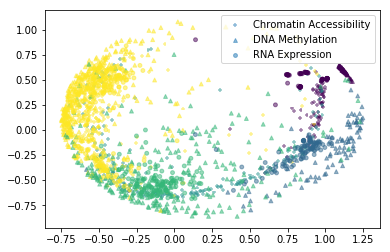

In [21]:
# plot the transport
Xyz_pca = pca.fit_transform(np.concatenate((X_new, y_new, z_new), axis=0))
X_pca = Xyz_pca[0:X.shape[0],]
y_pca = Xyz_pca[X.shape[0]:X.shape[0]+y.shape[0],]
z_pca = Xyz_pca[X.shape[0]+y.shape[0]:,]

plt.scatter(X_pca[:,0], X_pca[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = X_labels, marker = "+")
plt.scatter(y_pca[:,0], y_pca[:,1], s=15, label="DNA Methylation", alpha = 0.5, c = y_labels, marker = "^")
plt.scatter(z_pca[:,0], z_pca[:,1], s=15, label="RNA Expression", alpha = 0.5, c = z_labels, marker = "o")
plt.legend()
plt.show()

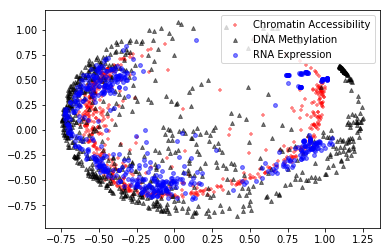

In [22]:
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = 'r', marker = "+")
plt.scatter(y_pca[:,0], y_pca[:,1], s=15, label="DNA Methylation", alpha = 0.5, c = 'k', marker = "^")
plt.scatter(z_pca[:,0], z_pca[:,1], s=15, label="RNA Expression", alpha = 0.5, c = 'b', marker = "o")
plt.legend()
plt.show()

In [23]:
lta = np.zeros(10)
for i in range(10):
    Xyz = np.concatenate(( X_new, y_new, z_new))
    Xyz_labels = np.concatenate((X_labels, y_labels, z_labels))
    sub_idx = np.random.permutation(Xyz.shape[0])
    Xyz = Xyz[sub_idx, :]
    Xyz_labels = Xyz_labels[sub_idx]

    lta[i]=evals.transfer_accuracy(Xyz[:(Xyz.shape[0] //2),:], Xyz[(Xyz.shape[0] //2):,:], 
                                Xyz_labels[:(Xyz.shape[0] //2)].reshape(-1, 1), Xyz_labels[(Xyz.shape[0] //2):].reshape(-1, 1), 5)

print("Label transfer accuracy for randomly splitting the alignment data is ", np.mean(lta))


../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(d

Label transfer accuracy for randomly splitting the alignment data is  0.8461699895068205


../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)


In [24]:
# compute label transfer accuracy between X and X
this_data = X_new
this_labels = X_labels

sub_idx = np.random.permutation(this_data.shape[0])
this_data = this_data[sub_idx,:]
this_labels = this_labels[sub_idx]

lta=evals.transfer_accuracy(this_data[:this_data.shape[0]//2,:], this_data[this_data.shape[0]//2:,:],
                            this_labels[:this_data.shape[0]//2], this_labels[this_data.shape[0]//2:], 5)
print("Label transfer accuracy for this alignment in X is: ", np.mean(lta))


Label transfer accuracy for this alignment in X is:  0.7705479452054794


In [25]:
# repeat average label transfer accuracy without the missing class
lta = np.zeros(10)
for i in range(10):
    Xyz = np.concatenate(( X_new, y_new[y_idx, :], z_new[z_idx, :]))
    Xyz_labels = np.concatenate((X_labels, y_labels[y_idx], z_labels[z_idx]))
    sub_idx = np.random.permutation(Xyz.shape[0])
    Xyz = Xyz[sub_idx, :]
    Xyz_labels = Xyz_labels[sub_idx]

    lta[i]=evals.transfer_accuracy(Xyz[:(Xyz.shape[0] //2),:], Xyz[(Xyz.shape[0] //2):,:], 
                                Xyz_labels[:(Xyz.shape[0] //2)].reshape(-1, 1), Xyz_labels[(Xyz.shape[0] //2):].reshape(-1, 1), 5)

print("Label transfer accuracy for randomly splitting the alignment data is ", np.mean(lta))

../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(domain2, type2)
../src/evals.py:140: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(d

Label transfer accuracy for randomly splitting the alignment data is  0.8419501133786849
